In [1]:
import gzip
import os
import sys
import urllib
import matplotlib.image as mpimg
from PIL import Image

import code

#import tensorflow.python.platform

import numpy
import tensorflow as tf
import tensorflow.keras as keras
from keras import layers, models, datasets,regularizers
from helpers_images import * 

In [35]:
RATIO_VALIDATION = 0.1
NUMBER_TRAINING_EXAMPLES = 100
NUMBER_TEST_EXAMPLES = 50
SAVE_MODEL = False
LOAD_MODEL = False
DATA_LOADED = False

In [3]:
training_data_directory = "../data/training/"
test_data_directory = "../data/test_set_images/"
if not(DATA_LOADED):    
    train_data, train_labels = extract_train_data(NUMBER_TRAINING_EXAMPLES,True,True), extract_labels(training_data_directory, NUMBER_TRAINING_EXAMPLES,True,True)
    DATA_LOADED = True

print(train_data.shape)
print(train_labels.shape)

Loading ../data/training/images/satImage_001.png
Loading ../data/training/images/satImage_002.png
Loading ../data/training/images/satImage_003.png
Loading ../data/training/images/satImage_004.png
Loading ../data/training/images/satImage_005.png
Loading ../data/training/images/satImage_006.png
Loading ../data/training/images/satImage_007.png
Loading ../data/training/images/satImage_008.png
Loading ../data/training/images/satImage_009.png
Loading ../data/training/images/satImage_010.png
Loading ../data/training/images/satImage_011.png
Loading ../data/training/images/satImage_012.png
Loading ../data/training/images/satImage_013.png
Loading ../data/training/images/satImage_014.png
Loading ../data/training/images/satImage_015.png
Loading ../data/training/images/satImage_016.png
Loading ../data/training/images/satImage_017.png
Loading ../data/training/images/satImage_018.png
Loading ../data/training/images/satImage_019.png
Loading ../data/training/images/satImage_020.png
Loading ../data/trai

Loading ../data/training/groundtruth/satImage_085.png
Loading ../data/training/groundtruth/satImage_086.png
Loading ../data/training/groundtruth/satImage_087.png
Loading ../data/training/groundtruth/satImage_088.png
Loading ../data/training/groundtruth/satImage_089.png
Loading ../data/training/groundtruth/satImage_090.png
Loading ../data/training/groundtruth/satImage_091.png
Loading ../data/training/groundtruth/satImage_092.png
Loading ../data/training/groundtruth/satImage_093.png
Loading ../data/training/groundtruth/satImage_094.png
Loading ../data/training/groundtruth/satImage_095.png
Loading ../data/training/groundtruth/satImage_096.png
Loading ../data/training/groundtruth/satImage_097.png
Loading ../data/training/groundtruth/satImage_098.png
Loading ../data/training/groundtruth/satImage_099.png
Loading ../data/training/groundtruth/satImage_100.png
(187500, 16, 16, 3)
(187500, 2)


In [4]:
c0 = 0
c1 = 0
for label in train_labels:
    if label[0] == 1:
        c0 += 1
    else:
        c1+= 1
c0, c1        

(138926, 48574)

In [5]:
def build_model():
    model = keras.Sequential()
    #model.add(layers.RandomFlip("horizontal_and_vertical"))
    #model.add(layers.RandomFlip("horizontal"))
    model.add(layers.RandomZoom(-0.3))
    model.add(layers.Conv2D(64, (1, 1), activation='elu', padding = "same"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (1, 1), activation='elu', padding = "same"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (1, 1), activation='elu', padding = "same"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(512, (1, 1), activation='elu', padding = "same"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(2))
    model.add(layers.Softmax())
    return model

In [6]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [7]:
model = build_model()
model.build(input_shape=(187500, 16, 16, 3))
model.summary()
model.compile(optimizer='adamax',
            loss= tf.keras.losses.CategoricalCrossentropy(from_logits=False),
            metrics=[f1_score, 'accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_zoom (RandomZoom)    (187500, 16, 16, 3)       0         
                                                                 
 conv2d (Conv2D)             (187500, 16, 16, 64)      256       
                                                                 
 max_pooling2d (MaxPooling2D  (187500, 8, 8, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (187500, 8, 8, 128)       8320      
                                                                 
 max_pooling2d_1 (MaxPooling  (187500, 4, 4, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (187500, 4, 4, 256)       3

In [8]:
model.layers

In [9]:
epochs = 100
if not(LOAD_MODEL):
    history = model.fit(train_data, train_labels, epochs=epochs, validation_split = RATIO_VALIDATION)

Epoch 1/100
5274/5274 [==============================] - 70s 13ms/step - loss: 0.5021 - f1_score: 0.7579 - accuracy: 0.7579 - val_loss: 0.4403 - val_f1_score: 0.8040 - val_accuracy: 0.8040
Epoch 2/100
5274/5274 [==============================] - 49s 9ms/step - loss: 0.4385 - f1_score: 0.7957 - accuracy: 0.7957 - val_loss: 0.4278 - val_f1_score: 0.7937 - val_accuracy: 0.7937
Epoch 3/100
5274/5274 [==============================] - 48s 9ms/step - loss: 0.4241 - f1_score: 0.8016 - accuracy: 0.8017 - val_loss: 0.4211 - val_f1_score: 0.8051 - val_accuracy: 0.8052
Epoch 4/100
5274/5274 [==============================] - 49s 9ms/step - loss: 0.4130 - f1_score: 0.8067 - accuracy: 0.8067 - val_loss: 0.3943 - val_f1_score: 0.8227 - val_accuracy: 0.8227
Epoch 5/100
5274/5274 [==============================] - 50s 9ms/step - loss: 0.4020 - f1_score: 0.8122 - accuracy: 0.8123 - val_loss: 0.3885 - val_f1_score: 0.8234 - val_accuracy: 0.8235
Epoch 6/100
5274/5274 [==============================] - 48

5274/5274 [==============================] - 49s 9ms/step - loss: 0.3086 - f1_score: 0.8617 - accuracy: 0.8618 - val_loss: 0.3194 - val_f1_score: 0.8586 - val_accuracy: 0.8586
Epoch 45/100
5274/5274 [==============================] - 49s 9ms/step - loss: 0.3070 - f1_score: 0.8635 - accuracy: 0.8635 - val_loss: 0.3090 - val_f1_score: 0.8635 - val_accuracy: 0.8635
Epoch 46/100
5274/5274 [==============================] - 50s 9ms/step - loss: 0.3061 - f1_score: 0.8637 - accuracy: 0.8637 - val_loss: 0.3104 - val_f1_score: 0.8656 - val_accuracy: 0.8656
Epoch 47/100
5274/5274 [==============================] - 49s 9ms/step - loss: 0.3040 - f1_score: 0.8650 - accuracy: 0.8650 - val_loss: 0.3081 - val_f1_score: 0.8634 - val_accuracy: 0.8634
Epoch 48/100
5274/5274 [==============================] - 49s 9ms/step - loss: 0.3041 - f1_score: 0.8650 - accuracy: 0.8650 - val_loss: 0.2981 - val_f1_score: 0.8688 - val_accuracy: 0.8688
Epoch 49/100
5274/5274 [==============================] - 49s 9ms/st

5274/5274 [==============================] - 47s 9ms/step - loss: 0.2665 - f1_score: 0.8835 - accuracy: 0.8835 - val_loss: 0.2662 - val_f1_score: 0.8861 - val_accuracy: 0.8861
Epoch 88/100
5274/5274 [==============================] - 47s 9ms/step - loss: 0.2632 - f1_score: 0.8844 - accuracy: 0.8844 - val_loss: 0.2839 - val_f1_score: 0.8755 - val_accuracy: 0.8755
Epoch 89/100
5274/5274 [==============================] - 48s 9ms/step - loss: 0.2654 - f1_score: 0.8841 - accuracy: 0.8841 - val_loss: 0.3427 - val_f1_score: 0.8523 - val_accuracy: 0.8523
Epoch 90/100
5274/5274 [==============================] - 49s 9ms/step - loss: 0.2640 - f1_score: 0.8844 - accuracy: 0.8844 - val_loss: 0.3246 - val_f1_score: 0.8616 - val_accuracy: 0.8617
Epoch 91/100
5274/5274 [==============================] - 49s 9ms/step - loss: 0.2629 - f1_score: 0.8852 - accuracy: 0.8852 - val_loss: 0.2822 - val_f1_score: 0.8814 - val_accuracy: 0.8814
Epoch 92/100
5274/5274 [==============================] - 49s 9ms/st

In [10]:
import matplotlib.pyplot as plt
def plot(parameter_name, small_window = False):
    plt.plot(history.history[parameter_name], label=parameter_name)
    plt.plot(history.history['val_' + parameter_name], label = 'val_' + parameter_name)
    plt.xlabel('Epoch')
    plt.ylabel(parameter_name.capitalize())
    if small_window:
        plt.ylim([0.1, 0.7])
    else:
        plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

In [11]:
history.history.keys()

dict_keys(['loss', 'f1_score', 'accuracy', 'val_loss', 'val_f1_score', 'val_accuracy'])

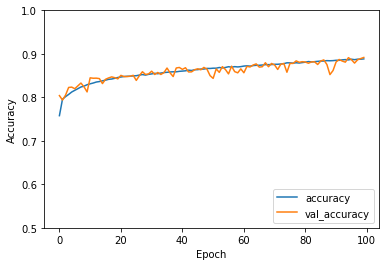

In [12]:
if not(LOAD_MODEL):
    plot('accuracy')

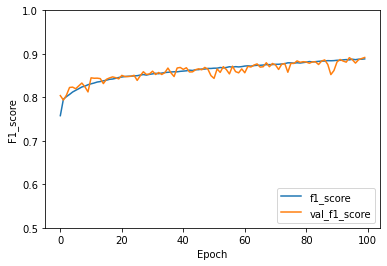

In [13]:
if not(LOAD_MODEL):
    plot('f1_score')

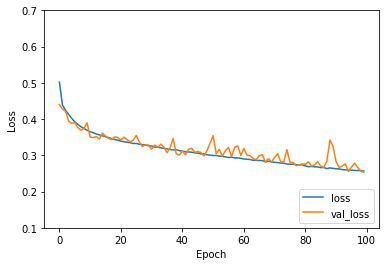

In [14]:
if not(LOAD_MODEL):
    plot('loss', True)

In [34]:
if LOAD_MODEL:
    loaded_model = tf.keras.models.load_model('model_seg.h5', custom_objects = {'f1_score': f1_score})
elif SAVE_MODEL:
    model.save("model_seg.h5")

In [16]:
if LOAD_MODEL:
    model = loaded_model

In [17]:
ex, label = train_data[0], train_labels[0]

In [18]:
train_data[0].shape

(16, 16, 3)

In [19]:
label

array([1., 0.], dtype=float32)

In [20]:
import pathlib

In [21]:
directory_path = pathlib.Path("../data/test_set_images/")

In [22]:
len(list(directory_path.glob('*/*.png')))

50

In [23]:
all_images = []
for i in range(1,51):
    image_in_directory = list(directory_path.glob("test_" + str(i) + "/*"))
    all_images.extend(image_in_directory)
img_height = img_width = 608

In [24]:
len(all_images)

50

In [25]:
all_images_arrays = []
for i in range(len(all_images)):
    img = tf.keras.utils.load_img(
        all_images[i], target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    all_images_arrays.append(img_array)
all_images_arrays = numpy.array(all_images_arrays)/255.0

In [26]:
all_images_arrays.max()

1.0

In [27]:
all_images_arrays.shape

(50, 608, 608, 3)

In [28]:
test_images = []
for i in range(len(all_images_arrays)):
    img_patched = extract_data_from_image(all_images_arrays[i])
    test_images.extend(img_patched)
test_images = numpy.array(test_images)

In [29]:
test_images.shape

(72200, 16, 16, 3)

In [30]:
predictions_testing = "predictions_testing/"
if not os.path.isdir(predictions_testing):
    os.mkdir(predictions_testing)

In [31]:
train_data[0].shape

(16, 16, 3)

In [32]:
stopper = input()
for i in range(len(all_images_arrays)):
    pimg,prediction = get_prediction_with_groundtruth(all_images_arrays[i], model)
    Image.fromarray(pimg[:,608:,:]).save(predictions_testing + "prediction_image_" + str(i+1) + ".png")
    Image.fromarray(pimg).save(predictions_testing + "prediction_" + str(i) + ".png")
    oimg = get_prediction_with_overlay(all_images_arrays[i], model)
    oimg.save(predictions_testing  + "overlay_" + str(i) + ".png")

go
